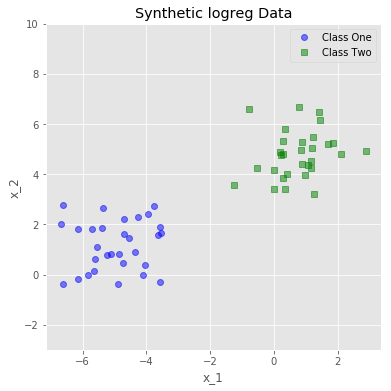

The Laplace Approximation is: 
 mean: 
 [0. 0.] 
 covariance: 
 [[100.   0.]
 [  0. 100.]]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
##################
## Load Imports ##
##################
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import plotting_helpers
# Load Exercise 2. Comment this out when the solutions are released.
%run ../02_laplace_approximation/02_laplace_approximation.ipynb

# Load Exercise 2 Solutions. Uncomment this when the solutions are released.
# %run ../02_laplace_approximation/02_laplace_approximation_solution.ipynb
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Set the random seed for PyTorch
seed = torch.manual_seed(1)


# 3 Bayesian Logistic Regression: Variational Inference

In this exercise, we will continue to explore methods for approximate Bayesian inference in logistic regression. We previously focused on the Laplace approximation. We will now focus on Variational Inference (VI). We will continue to use the same toy dataset as before and do the following:

1. Implement a stochastic estimator of the evidence lower bound (ELBO) (Section [3.1](#3.1-Gaussian-Variational-Inference)). 
2. Use the ELBO to compute a Gaussian variational approximation to the true posterior distribution (Section [3.1](#3.1-Gaussian-Variational-Inference)).
5. **Optional**: Derive and implement the reparameterization trick gradients for the expected log-likelihood (Section [3.2](#3.2-Gradient-Estimators))

We use the same 2D synthetic dataset as was used in exercise two. Data is taken from Kevin Murphy's Machine Learning: a Probabilistic Perspective.

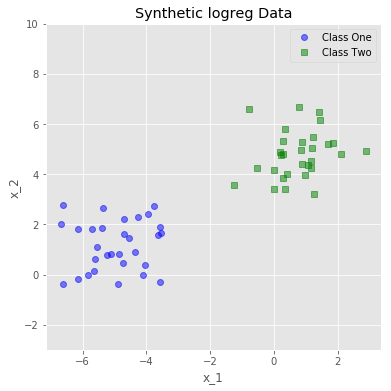

In [2]:
def logreg_synthetic_data(N=60, std1=1, std2=1.1):
    ''' Generate a binary classification dataset where the features for the two classes are
        sampled from different 2-dimensional Gaussians.
    '''
    mid_index = math.floor(N/2)
    
#   define different mean vectors for the two different classes.
    mu1 = torch.stack([torch.ones(mid_index), torch.ones(N-mid_index)*5],dim=1)
    mu2 = torch.stack([torch.ones(mid_index)*-5, torch.ones(N-mid_index)], dim=1)

#   sample features from normal distributions.
    X = torch.cat([
        torch.normal(mean=mu1, std=std1),
        torch.normal(mean=mu2, std=std2)])
    
#   class labels are in the set {0,1}.
    y = torch.ones(N)
    y[mid_index:N] = y[mid_index:N] - 1

    return X, y

X, y  = logreg_synthetic_data()

lam = 0.01 # Prior precision
mu_prior = torch.zeros(2) # Prior Mean
Sigma_prior = torch.eye(2) / lam

# plot the data set.
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

plotting_helpers.plot_logreg_data(ax1, X.detach().numpy(), y.detach().numpy())

## 3.1 Gaussian Variational Inference

The mean of the Laplace Approximation is the **mode** of the posterior distribution, rather than the **mean**. This means that the Laplace Approximation can place significant probability mass on poor model parameters for skewed distribution, like the posterior above. VI does not have this problem and is a better method for approximating the posterior.

We will approximate the true posterior with a Gaussian variational distribution $q(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w} | \boldsymbol{\mu}, \Sigma)$ where $\Sigma$ is positive definite covariance matrix. VI optimizes the evidence lower bound (ELBO) instead of the MAP objective. Recall that the ELBO is given by

$$ \mathcal{L}_{ELBO} = \mathbb{E_q} \left[ \log p(\mathcal{D} | \boldsymbol{w}) \right] - D_{KL}(q(\boldsymbol{w})||p(\boldsymbol{w}))$$

where $D_{KL}(q(\boldsymbol{w})||p(\boldsymbol{w}))$ is the KL divergence between $q$ and the prior distribution. The ELBO is a lower bound on the marginal likelihood $p(\mathcal{D})$ and maximizing the ELBO is equivalent to minimizing $D_{KL}(q(\boldsymbol{w})||p(\boldsymbol{w} | \mathcal{D}))$. We will minimize the negative ELBO for consistency with the MAP estimation code above. 

One difficuly that we must address is that Gaussian VI is a constrained optimization problem because the covariance matrix $\Sigma$ must be positive definite for $q$ to be a valid Gaussian distribution. As a solution, we reparameterize $q$ with the Cholesky factor $L$ of the covariance:

$$\Sigma = L L^\top.$$

Using the factor $L$ insures that $\Sigma$ remains positive definite since only symmetric, positive definite matrices have a Cholesky factorization. It is also numerically convenient. We convert the constrained VI optimization problem into an unconstrained one in this manner.

### Your Tasks:
* Complete the implementations of ```sample_model```, ```expected_log_likelihood``` and ```elbo``` by filling in the missing computations.
* Compute the variational approximation to the posterior by minimizing the negative elbo (see ```compute_variational_approximation```)
* The implementation of $D_{KL}(q(\boldsymbol{w})||p(\boldsymbol{w}))$ and its gradients is already provided.
* The gradients of $\mathbb{E}_q \left[ p(\mathcal{D} | \boldsymbol{w}) \right]$ can be obtained using the ```autograd_estimator``` function, which uses PyTorch's automatic differentiation to compute the reparameterization trick gradients.


In [3]:
### Provided Utilities ###
def log_likelihood(X, y, w):
    ''' Computes and returns the value, gradient, and Hessian of the negative log-likelihood of the data
        (X,y) evaluated at w.
        Parameters:
            X: dataset features
            y: dataset labels
    '''
    (N, _) = X.size()
    logits = torch.mv(X, w)
    probs = torch.sigmoid(logits).clamp(min=1e-6, max=1-1e-6)
    nll = -1 * torch.sum(y * torch.log(probs) + (1 - y) * torch.log(1 - probs))

    g = torch.mv(X.t(), (probs - y))
    H = torch.mm(torch.mm(X.t(), torch.diag((probs * (1 - probs)))), X)

    return nll, g, H

def kl_divergence(lam, mu, L):
    ''' Computes KL(q||p): the reverse KL divergence between a multivariate Gaussian distribution q 
        and p, a multivariate gaussian with mean 0 and covariance I / lam.
        Parameters:
            lam: the precision of the prior distribution
            mu: the mean of distribution q
            L: the (lower triangular) Cholesky factor of q's covariance (recall Sigma = LL^\top) 
    '''
    prior_prec = torch.ones_like(mu) * lam
    Sigma = torch.mm(L, L.t())
    Sigma_det = torch.log(torch.diag(L)).sum().mul(2)
    D = mu.size()[0]
    ld = torch.log(1/prior_prec).sum() - Sigma_det
    kl = torch.trace(Sigma.mul(prior_prec)) + ld + torch.dot(mu.mul(prior_prec), mu) - D
    kl = kl.div(2)
    
    mu_grad = mu * lam
    L_grad = torch.mm(torch.eye(mu.size()[0]) * lam, L + L.t()) / 2 - torch.inverse(L)
    
    return kl, mu_grad, L_grad


def autograd_estimator(lam, nll, epsilon, g, H, mu, L):
    ''' Computes the gradient of nll with respect to mu and L using PyTorch's built-in automatic
        differentiation. This function assumes that a nll was computed using w_s,
        a parameter vector sampled from q(w) = N(w|u, LL').
        Only the nll, mu and L arguments are required; the other arguments are
        required by different gradient estimators and are kept to retain a unified function signature.
        Parameters:
            lam: the precision of the prior distribution
            nll: the negative log-likelihood
            epsilon: the (standard normal) noise vector used to compute w_s with the 
                reparameterization trick.
    '''
    
    mu_grad = torch.autograd.grad(nll, mu, retain_graph=True)[0]
    L_grad = torch.autograd.grad(nll, L, retain_graph=True)[0]

    return mu_grad, L_grad
### Provided Utilities ###

In [4]:
### TASKS BEGIN ###
def sample_model(mu, L):
    ''' Samples a model parameter vector (w_s) from the Gaussian distribution defined as
        N(w|mu, LL')
        Paramters:
            mu: the mean of the distribution to sample from.
            L: the lower triangular Cholesky factor of the distribution's covariance.
    '''
    ### implement sampling from the approximate posterior here ###
    
    epsilon = torch.zeros_like(mu)
    w_s = mu

    return w_s, epsilon

def expected_log_likehood(lam, X, y, mu, L, num_samples=10, gradient_estimator=autograd_estimator):
    ''' Approximates the value and gradients (for both mu and L) of the expectation of the negative log-likelihood 
        under the variational distribution q using Monte-Carlo integration.
        Parameters:
            lam: precision of the prior distribution
            X: dataset features
            y: dataset labels
            mu: the mean of q
            L: the lower triangular Cholesky factor of q's covariance.
            num_samples: the number of samples used to estimate the integral
            gradient_estimator: the function used to compute the gradient of the negative log-likelihood
                with respect to mu and L. 
    ''' 
    nll_hat = 0
    mu_grad_hat = torch.zeros_like(mu)
    L_grad_hat = torch.zeros_like(L)

    for s in range(num_samples):
        w_s, epsilon = sample_model(mu, L)
        
        ### fill in your solution here ###
        
    return nll_hat, mu_grad_hat, L_grad_hat

def elbo(lam, X, y, mu, L, num_samples=10, gradient_estimator=autograd_estimator):
    ''' Computes and returns a stochastic estimates of the ELBO and the gradients of the
        ELBO with respect to mu and L.
        Parameters:
            lam: precision of the prior distribution
            X: dataset features
            y: dataset labels
            mu: the mean of q
            L: the lower triangular Cholesky factor of q's covariance.
            num_samples: the number of samples used to estimate the integral
            gradient_estimator: the function used to compute the gradient of the negative log-likelihood
                with respect to mu and L. 
    ''' 
    ### fill in your implementation of the ELBO here ###
    
    elbo = 0
    mu_grad_hat = torch.zeros_like(mu)
    L_grad_hat = torch.zeros_like(L)
    

    return elbo, mu_grad_hat, L_grad_hat
### TASKS END ###

In [5]:
### Variational Inference Training Loop ###
def compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L, gradient_estimator):
    ''' Basic training loop for variational inference
    '''
    
    objective_history = []
    mu_history = mu.unsqueeze(0)
    for i in range(max_iters):
        negative_elbo, mu_grad, L_grad = elbo(lam, X, y,  mu, L, num_samples, gradient_estimator=gradient_estimator)
        mu = mu - alpha * mu_grad
        L = L - alpha * L_grad

        # Record ELBO and distribution means for visualization
        objective_history.append(negative_elbo)
        mu_history = torch.cat([mu_history, mu.unsqueeze(0)], dim=0)

    return mu, L, objective_history, mu_history

# Initial model
mu = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
Sigma = torch.eye(2, requires_grad=True) / lam
# Compute the Cholesky decomposition of the covariance
L = torch.potrf(Sigma, upper=False)

max_iters = 200
num_samples = 50
alpha = 0.01

mu_vi, L_vi, objective_history, mu_history = compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L=L, gradient_estimator=autograd_estimator)
# Recover the covariance matrix from the Cholesky decomposition.
Sigma_vi = torch.mm(L_vi, L_vi.t())
print('The Variational Approximation is: \n mean: \n', mu_vi.detach().numpy(), '\n covariance: \n', Sigma_vi.detach().numpy())


The Variational Approximation is: 
 mean: 
 [0. 0.] 
 covariance: 
 [[100.   0.]
 [  0. 100.]]


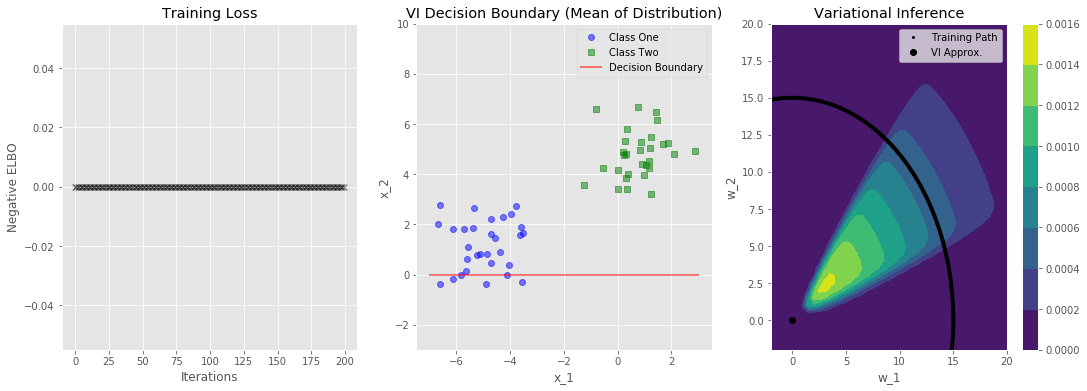

In [6]:
### Visualize the Variational Approximation ###
plotting_helpers.visualize_variational_approximation(objective_history,mu_history,max_iters,w1,w2,posterior_density,mu_vi,Sigma_vi,X,y)

### Comparing VI and the Laplace Approximation

We now compare the VI and Laplace Approximation by examining their respective posteriors and sampling decision boundaries from each distribution.

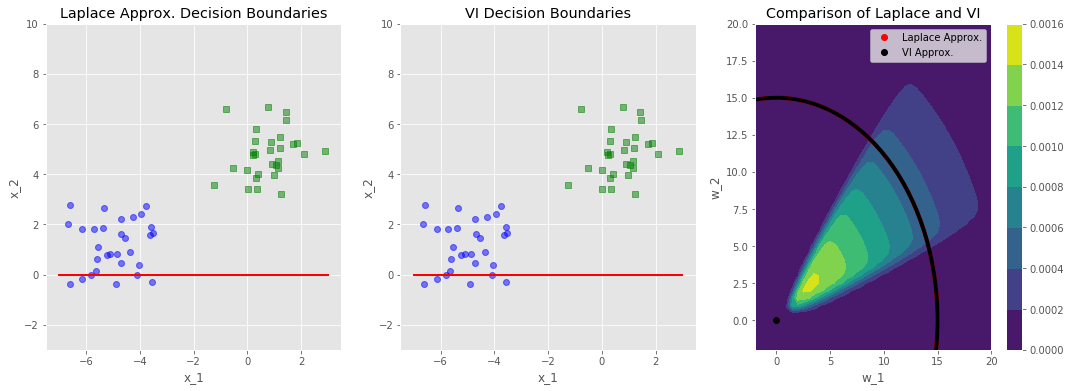

In [7]:
L_la = torch.potrf(Sigma_la, upper=False)
### Compare approximate posteriors from VI and LA ###
plotting_helpers.visualize_VI_vs_LA(w1,w2,posterior_density,sample_model,mu_la,L_la, Sigma_la,mu_vi,L_vi, Sigma_vi,X,y)

## 3.2 Gradient Estimators

There are several different unbaised, stochastic estimators of the ELBO gradients: the reparameterization trick, the score function estimator (also called REINFORCE), and the charateristic function estimator (given by Bonnet's and Price's theorems). We used the reparameterization trick in the above implementation and computed the estimator automatically using PyTorch. However, the reparameterization trick gradients can be derived and implemented by hand.

### Your Tasks (Optional)
* Manually implement the reparameterization trick gradients for the expected log-likelihood.
* Your implementation should only need the Gaussian noise vector ```epsilon``` and the gradient ```g```.

In [8]:
### TASKS BEGIN ###
def reparameterization_estimator(lam, nll, epsilon, g, H, mu, L):
    ''' Computes the gradient of nll with respect to mu and L using the reparameterization trick.
        This function is a "manual" implementation of autograd_estimator, which uses PyTorch's automatic
        differentiation. This function assumes that a nll was computed using w_s,
        a parameter vector sampled from q(w) = N(w|u, LL').
        Parameters:
            lam: the precision of the prior distribution
            nll: the negative log-likelihood
            epsilon: the (standard normal) noise vector used to compute w_s with the 
                reparameterization trick.
    '''
    ### implement reparameterization gradients of the log-likelihood here ###
    
    mu_grad = torch.zeros_like(mu)
    L_grad = torch.zeros_like(L)

    return mu_grad, L_grad
### TASKS END ###

In [9]:
# Initial model
mu_reparam = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
Sigma_reparam = torch.eye(2, requires_grad=True) / lam
# Compute the Cholesky decomposition of the covariance
L_reparam = torch.potrf(Sigma, upper=False)

max_iters = 1000
num_samples = 50
alpha = 0.05

mu_reparam, L_reparam, objective_history_reparam, mu_history_reparam = compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L=L, gradient_estimator=reparameterization_estimator)
# Recover the covariance matrix from the Cholesky decomposition.
Sigma_reparam = torch.mm(L_reparam, L_reparam.t())
print('The Variational Approximation is: \n mean: \n', mu_reparam.detach().numpy(), '\n covariance: \n', Sigma_reparam.detach().numpy())


The Variational Approximation is: 
 mean: 
 [0. 0.] 
 covariance: 
 [[100.   0.]
 [  0. 100.]]


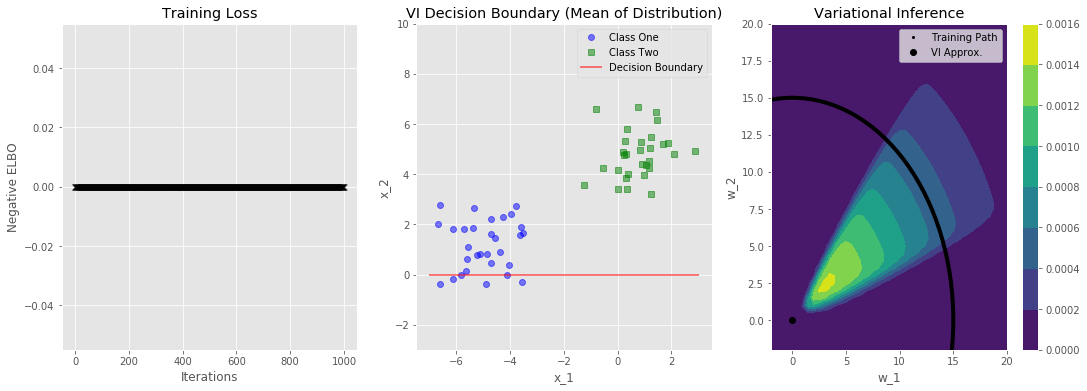

In [10]:
### Visualize Variational Inference with Manual Reparameterization Trick ###
plotting_helpers.visualize_variational_approximation(objective_history_reparam,mu_history_reparam,max_iters,w1,w2,posterior_density,mu_reparam,Sigma_reparam,X,y)